In [3]:
%matplotlib inline
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
import pandas as pd

from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import os
from sklearn import metrics

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)



# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
    
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    

preprocess = True

filename_read = os.path.join(r"C:\Users\siris\OneDrive\Desktop\215\mini-project2\CSC215_P2_Stock_Price.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

df.drop('Date', axis=1, inplace=True)
df.drop('Adj_Close', axis=1, inplace=True)
if preprocess:
    encode_numeric_zscore(df, 'Open')
    encode_numeric_zscore(df, 'High')
    encode_numeric_zscore(df, 'Low')
    encode_numeric_zscore(df, 'Volume')

    
x,y = to_xy(df,'Close')



x=np.concatenate((x, y[:,None]), 1)


In [11]:

last = y.shape[0]
i = 0
#X_Row = np.concatenate((x[i],y[i]), axis=None)
X_Row = x[i]
for j in range(1,10):
    X_Row = np.concatenate((X_Row, x[i+j]), axis=None)
X = X_Row
Y = y[10]
i = i + 1

while i < (last-10):
    X_Row = x[i]
    for j in range(1,10):
        X_Row = np.concatenate((X_Row, x[i+j]), axis=None)
    X = np.vstack((X, X_Row))
    Y = np.concatenate((Y, y[i+10]), axis=None)    
    i = i + 1

x_train, x_test, y_train, y_test = train_test_split(X , Y , test_size=0.30, random_state=42)
import tensorflow as tf
tf.__version__



'2.1.0'

In [12]:
checkpointer = ModelCheckpoint(filepath=r"C:\Users\siris\OneDrive\Desktop\215\mini-project2\best_weights2.hdf5", verbose=0, save_best_only=True)
for i in range(5):
    print(i)
    model = Sequential()
    model.add(Dense(30, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=12, verbose=1, mode='auto')
     # save best model

    # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
    model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 128, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
print('Training finished...Loading the best model')  
print()
model.load_weights(r"C:\Users\siris\OneDrive\Desktop\215\mini-project2\best_weights2.hdf5") # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)


#pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
print(pred)

0
Train on 3067 samples, validate on 1315 samples
Epoch 1/1000
3067/3067 - 0s - loss: 507.2607 - val_loss: 11.1434
Epoch 2/1000
3067/3067 - 0s - loss: 22.2198 - val_loss: 6.0666
Epoch 3/1000
3067/3067 - 0s - loss: 5.9020 - val_loss: 4.0643
Epoch 4/1000
3067/3067 - 0s - loss: 4.3573 - val_loss: 3.8793
Epoch 5/1000
3067/3067 - 0s - loss: 3.9392 - val_loss: 3.5658
Epoch 6/1000
3067/3067 - 0s - loss: 3.8093 - val_loss: 3.5348
Epoch 7/1000
3067/3067 - 0s - loss: 3.7256 - val_loss: 3.4927
Epoch 8/1000
3067/3067 - 0s - loss: 3.5797 - val_loss: 3.2214
Epoch 9/1000
3067/3067 - 0s - loss: 3.2334 - val_loss: 3.0692
Epoch 10/1000
3067/3067 - 0s - loss: 2.9812 - val_loss: 2.8395
Epoch 11/1000
3067/3067 - 0s - loss: 2.8109 - val_loss: 2.7035
Epoch 12/1000
3067/3067 - 0s - loss: 2.6485 - val_loss: 2.6473
Epoch 13/1000
3067/3067 - 0s - loss: 2.4415 - val_loss: 2.5007
Epoch 14/1000
3067/3067 - 0s - loss: 2.2299 - val_loss: 2.2950
Epoch 15/1000
3067/3067 - 0s - loss: 1.9600 - val_loss: 2.1738
Epoch 16/1

Score (RMSE): 0.9603145122528076


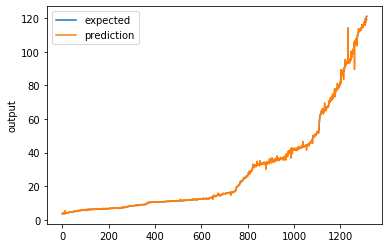

In [13]:
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test, sort=True)

